In [1]:
import os
import time
import psycopg2
from psycopg2 import Error
import re
import pandas as pd
import requests
from psycopg2 import sql
from convertdate import persian
import plotly.graph_objects as go
from persiantools.jdatetime import JalaliDate
import plotly.graph_objects as go
import pandas as pd
from IPython.display import display, HTML
import sqlite3

In [2]:
def clean_value(value):
    if value == '-' or not value:
        return value

    match = re.search(r'<span class="(?:low|high)" dir="ltr">([\d%,]+)<', value)

    if match:
        number = match.group(1).replace(',', '')  # Remove commas

        if 'class="high"' in value:
            return number
        elif 'class="low"' in value:
            return f'-{number}'

    return value.strip()


In [3]:
def fetch_and_process_data(url):
    response = requests.get(url)
    data_json = response.json()

    # Extract data from JSON
    data = data_json.get('data', [])

    # Process the data
    processed_data = []
    for row in data:
        row_data = [clean_value(item) for item in row]
        processed_data.append(row_data)

    # Create DataFrame with column names
    df = pd.DataFrame(processed_data,
                      columns=['opening', 'lowest', 'highest', 'closing', 'change_amount', 'change_percentage',
                               'gregorian_date',
                               'persian_date'])

    # Select relevant columns
    df_filtered = df[['closing', 'persian_date', 'gregorian_date']]

    # Convert 'closing' to numeric
    df_filtered.loc[:, 'closing'] = df_filtered['closing'].replace({',': ''}, regex=True).astype(float)

    return df_filtered

In [3]:
conn = sqlite3.connect('market_data.db')

In [5]:
# URLs for different types of data
urls = {
    'Gold': 'https://api.tgju.org/v1/market/indicator/summary-table-data/geram18?lang=fa&order_dir=asc&convert_to_ad=1&_=',
    'Dollar': 'https://api.tgju.org/v1/market/indicator/summary-table-data/price_dollar_rl?lang=fa&order_dir=asc&convert_to_ad=1&_=',
    'Coin': 'https://api.tgju.org/v1/market/indicator/summary-table-data/sekee?lang=fa&order_dir=asc&convert_to_ad=1&_=',
    'Nim-Coin': 'https://api.tgju.org/v1/market/indicator/summary-table-data/nim?lang=fa&order_dir=asc&convert_to_ad=1&_=',
    'Coin-Gerami': 'https://api.tgju.org/v1/market/indicator/summary-table-data/gerami?lang=fa&order_dir=asc&convert_to_ad=1&_=',
    'Bitcoin': 'https://api.tgju.org/v1/market/indicator/summary-table-data/crypto-bitcoin?lang=fa&order_dir=asc&convert_to_ad=1&_=',
    'Rob-Coin': 'https://api.tgju.org/v1/market/indicator/summary-table-data/rob?lang=fa&order_dir=asc&convert_to_ad=1&_='
}

all_df = []

# Fetch and process the data
for market_name, url in urls.items():
    fetched_data_df = fetch_and_process_data(url)

    fetched_data_df['year_month'] = fetched_data_df['persian_date'].str[:7]  # Take 'YYYY/MM' from 'YYYY/MM/DD'

    fetched_data_df['market_type'] = market_name

    all_df.append(fetched_data_df)

df = pd.concat(all_df, ignore_index=True)

# Read existing data from the table
try:
    existing_data = pd.read_sql_query("SELECT * FROM market_data", conn)
except Exception as e:
    # If the table doesn't exist, create an empty DataFrame with the same structure
    existing_data = pd.DataFrame()

# Check for new rows to insert (rows that are not already in the table)
if not existing_data.empty:
    # Perform a row-wise comparison using all columns
    new_data = df.merge(existing_data, how='outer', indicator=True).query('_merge == "left_only"').drop(columns='_merge')
else:
    # If the table is empty, all rows in `market_data` are new
    new_data = df

# Insert only the new data
if not new_data.empty:
    new_data.to_sql('market_data', conn, if_exists='append', index=False)
    print(f"Inserted {len(new_data)} new records.")
else:
    print("No new records to insert.")

# Commit and close
conn.commit()
conn.close()

In [10]:
df = pd.read_sql_query("SELECT * FROM market_data", conn)

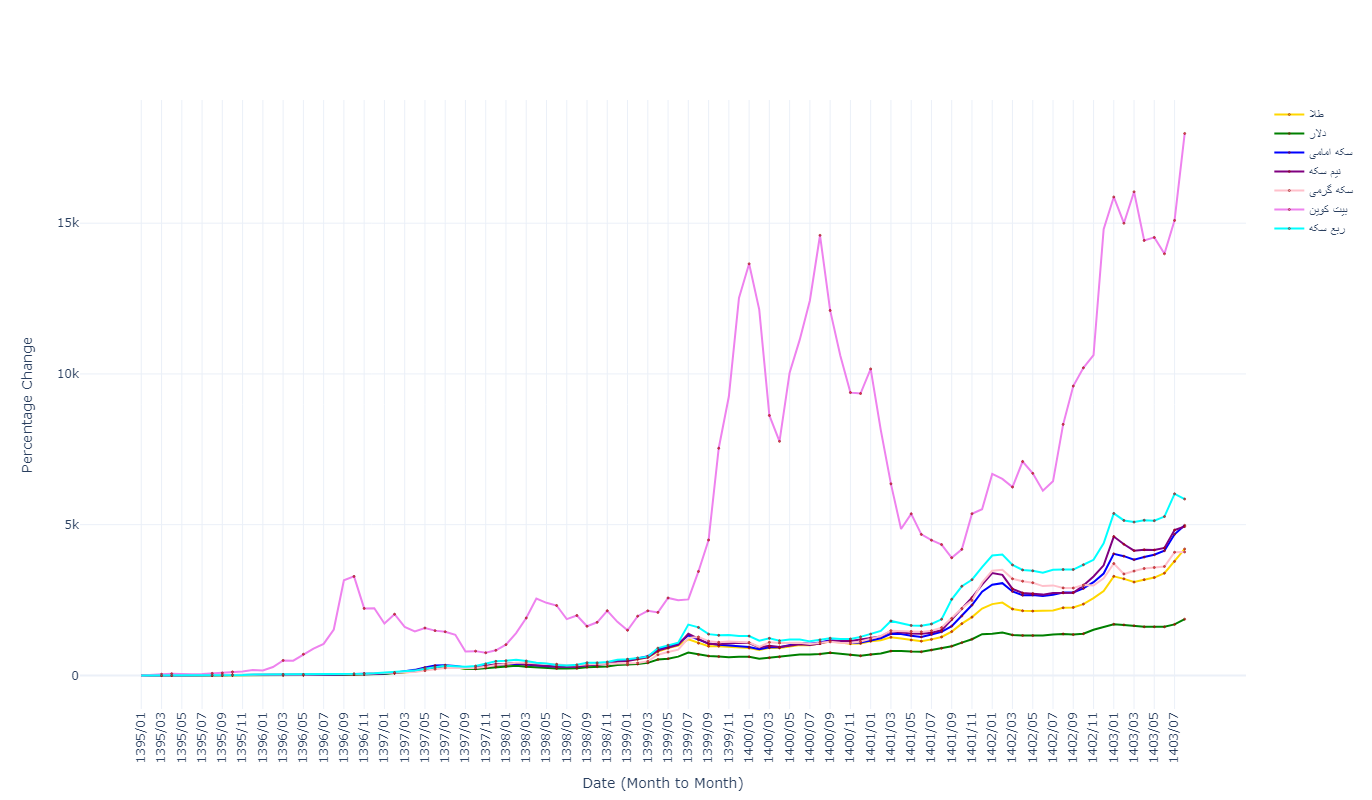

In [16]:
def convert_persian_to_jalali(persian_date):
    year, month, day = map(int, persian_date.split('/'))  # Split and convert to integers
    return JalaliDate(year, month, day)

df['persian_date_jalali'] = df['persian_date'].apply(convert_persian_to_jalali)

all_data_df = df

df = df[df['persian_date_jalali'] > JalaliDate(1395, 1, 1)]

# Group by market type and year_month
market_names = {
  "Coin": "سکه امامی",
  "Bitcoin": "بیت کوین",
  "Nim-Coin": "نیم سکه",
  "Gold": "طلا",
  "Dollar": "دلار",
  "Rob-Coin": "ربع سکه",
  "Coin-Gerami": "سکه گرمی"  
}

monthly_data_dict = {}

for market_type in df['market_type'].unique():
    market_data = df[df['market_type'] == market_type]

    # Calculate monthly average price and percentage change
    grouped = market_data.groupby('year_month').agg(
        avg_closing_price=('closing', 'mean')
    )
    grouped['price_change'] = (grouped['avg_closing_price'] / grouped['avg_closing_price'].iloc[0] - 1) * 100

    # Add data to dictionary
    monthly_data_dict[market_names.get(str(market_type), 'Unknown')] = {
        'year_month': grouped.index.tolist(),
        'price_change': grouped['price_change'].tolist()
    }

# Custom height for the output cell
display(HTML('<style>.output { height: 800px; overflow-y: scroll; }</style>'))

# Load events data from CSV
events_df = pd.read_csv("events.csv")

colors = {
    "بیت کوین": "violet",
    "طلا": "gold",
    "دلار": "green",
    "سکه امامی": "blue",
    "نیم سکه": "purple",
    "ربع سکه": "cyan",
    "سکه گرمی": "pink"
}

# Create a figure
fig = go.Figure()

# Iterate over the monthly data dictionary to add traces for each market
for name, monthly_data in monthly_data_dict.items():
    hover_texts = []
    marker_colors = []
    marker_sizes = []

    for date in monthly_data['year_month']:
        # Check if any events match this date
        matching_events = events_df[events_df['Date'] == date]
        if not matching_events.empty:
            # Combine all matching event names into one hover text
            event_names = "<br>".join(matching_events['Event'].tolist())
            hover_texts.append(f"<b>{event_names}</b>")
            marker_colors.append('yello')  # Highlight event points in red
            marker_sizes.append(2)  # Highlight event points with larger size
        else:
            hover_texts.append("")  # No event for this date
            marker_colors.append('rgba(0,0,0,0)')  # Transparent color for non-event points
            marker_sizes.append(0)  # Invisible marker size

    # Add trace for each market
    fig.add_trace(go.Scatter(
        x=monthly_data['year_month'],
        y=monthly_data['price_change'],
        mode='lines+markers',
        name=name,
        hoverinfo="text",  # Only show custom hover text
        text=hover_texts,  # Custom hover text
        marker=dict(
            color=marker_colors,  # Assign colors based on event occurrence
            size=marker_sizes,  # Show marker size only for events
            line=dict(width=1, color="darkred")  # Optional: outline markers
        ),
        line=dict(color=colors.get(name, "black"), width=2)  # Default to black if not in colors
    ))

# Chart settings
fig.update_layout(
    xaxis_title="Date (Month to Month)",
    yaxis_title="Percentage Change",
    xaxis=dict(
        type="category",
        tickangle=-90
    ),
    template='plotly_white',
    showlegend=True,
    height=800  # Set the height of the entire chart
)

# Display the figure
fig.show()


In [8]:
fig.write_html("interactive_chart.html")

In [8]:
Date,Event
1390/05,ترور داریوش رضایی نژاد در جریان جنگ نیابتی ایران و اسرائیل و ترور شخصیت های هسته ای ایران
1390/08,انفجار بیدگنه در پایگاه موشکی مدرس و کشته شدن ۲۷ نفر از اعضای سپاه پاسداران از جمله حسن طهرانی مقدم
1390/09,حمله به سفارت بریتانیا در تهران توسط لباس شخصی ها
1390/09,دستیابی به پهپاد آرکیو ۱۷۰ آمریکا در خاک ایران
1390/10,ترور مصطفی احمدی روشن در جریان جنگ نیابتی ایران و اسرائیل و ترور شخصیت های هسته ای ایران
1391/03,آغاز به کار دوره نهم مجلس شورای اسلامی با اکثریت جناح اصول گرایان به ریاست علی لاریجانی
1391/07,اعتراضات در بازار تهران در پی افزایش قیمت دلار و سقوط ارزش پول ملی و بی ثباتی اقتصادی
1392/03,آغاز مداخله نظامی جمهوری اسلامی ایران در جنگ داخلی سوریه
1392/05,انتخاب حسن روحانی به عنوان هفتمین رئیس جمهور ایران
1393/07,درگذشت محمدرضا مهدوی کنی
1393/12,انتخاب محمد یزدی به عنوان چهارمین رئیس مجلس خبرگان رهبری
1394/07,فاجعه منا
1394/10,حمله به سفارت و کنسولگری عربستان سعودی در ایران توسط لباس شخصی ها و قطع رابطه دیپلماتیک عربستان سعودی و ۵ کشور عربی دیگر با ایران
1394/10,دستگیری ملوانان آمریکایی توسط نیروی دریایی سپاه پاسداران
1394/10,آغاز اجرای برجام
1395/03,انتخاب احمد جنتی به عنوان پنجمین رئیس مجلس خبرگان رهبری
1395/03,آغاز به کار دوره دهم مجلس شورای اسلامی با اکثریت جناح اصلاح طلبان و جناح اعتدال گرایان به ریاست علی لاریجانی
1395/09,درگذشت سید عبدالکریم موسوی اردبیلی
1395/10,درگذشت اکبر هاشمی رفسنجانی
1395/10,آتش سوزی و ریزش ساختمان پلاسکو
1396/03,حملات تروریستی داعش به ساختمان مجلس شورای اسلامی و آرامگاه سید روح الله خمینی
1396/03,حملات موشکی سپاه پاسداران به مقر داعش در دیرالزور سوریه در پاسخ به حملات داعش در تهران
1396/05,انتخاب مجدد حسن روحانی به ریاست جمهوری
1396/05,انتصاب سید محمود هاشمی شاهرودی به عنوان سومین رئیس مجمع تشخیص مصلحت نظام
1396/10,آغاز اعتراضات سراسری بر ضد حکومت جمهوری اسلامی و کشته شدن دست کم ۵۰ تن از معترضان توسط جمهوری اسلامی
1396/10,راهپیمایی هایی هواداران جمهوری اسلامی بر ضد اعتراضات سراسری مردم
1396/10,حادثه نفت کش سانچی
1396/11,آغاز اعتراضات گلستان هفتم دراویش گنابادی به ایجاد محدودیت و حصر خانگی علیه نورعلی تابنده
1396/11,سقوط هواپیمای شماره ۳۷۰۴ در اثر اصابت به کوه دنا
1397/02,آغاز فیلترینگ تلگرام در ایران توسط حکومت
1397/02,خروج آمریکا از برجام و بازگشت تحریم ها
1397/05,آغاز اعتراضات مرداد ۱۳۹۷ ایران
1397/06,حمله به رژه نظامی در اهواز
1397/07,عملیات ضربت محرم در پاسخ به حمله به رژه نظامی در اهواز
1397/10,درگذشت سید محمود هاشمی شاهرودی
1397/10,انتصاب صادق لاریجانی به عنوان چهارمین رئیس مجمع تشخیص مصلحت نظام
1397/10,سقوط هواپیمای بوئینگ ۷۰۷ ارتش جمهوری اسلامی ایران
1397/11,حمله به اتوبوس کارکنان سپاه زاهدان توسط گروه جیش العدل و کشته شدن ۲۴ تن
1397/12,انتصاب سید ابراهیم رئیسی به عنوان هفتمین رئیس قوه قضائیه
1398/01,قرار گرفتن سپاه پاسداران در فهرست گروه های تروریستی از سوی دولت آمریکا
1398/03,سرنگونی پهپاد آمریکایی توسط ایران
1398/06,خودسوزی دختر آبی
1398/08,آغاز اعتراضات سراسری در آبان ماه به گرانی قیمت بنزین و قطعی سراسری اینترنت و کشته شدن بیش از ۱٫۵۰۰ تن از معترضان به دست حکومت جمهوری اسلامی
1398/10,حمله هوایی آمریکا در فرودگاه بین المللی بغداد و کشتن قاسم سلیمانی و ابومهدی المهندس
1398/10,حمله نیروی هوافضای سپاه پاسداران به پایگاه آمریکایی عین الاسد در عراق در پاسخ به کشتن قاسم سلیمانی
1398/10,اعتراضات مردمی در پی سرنگونی پرواز شماره ۷۵۲ هواپیمایی بین المللی اوکراین توسط سپاه پاسداران
1398/11,آغاز دنیاگیری کووید-۱۹ در ایران
1399/02,سانحه شناور پشتیبان کنارک
1399/03,آغاز به کار دوره یازدهم مجلس شورای اسلامی با اکثریت جناح اصول گرایان به ریاست محمدباقر قالیباف
1399/04,انفجار تأسیسات هسته ای نطنز
1399/05,ترور عبدالله احمد عبدالله، فرد دوم القاعده، به همراه دخترش، در خیابان پاسداران تهران
1399/09,ترور محسن فخری زاده در جریان جنگ نیابتی ایران و اسرائیل و ترور شخصیت های هسته ای ایران
1399/09,درگذشت محمد یزدی
1399/09,اعدام روح الله زم توسط حکومت به اتهام محاربه
1399/10,درگذشت محمدتقی مصباح یزدی
1400/01,انعقاد برنامه ۲۵ ساله همکاری های مشترک ایران و چین
1400/03,انتخاب سید ابراهیم رئیسی به عنوان هشتمین رئیس جمهور ایران
1400/04,انتصاب غلامحسین محسنی اژه ای به عنوان هشتمین رئیس قوه قضائیه
1400/11,درگذشت لطف الله صافی گلپایگانی
1400/12,حمله موشکی سپاه پاسداران به اربیل عراق
1401/01,حادثه ۱۴۰۱ حرم امام رضا
1401/03,فروریختن ساختمان متروپل در آبادان
1401/05,حمله با چاقو به سلمان رشدی و حمایت جمهوری اسلامی از این عمل، با پشتوانه فتوای خمینی به ارتداد سلمان رشدی، پس از انتشار کتاب آیات شیطانی
1401/06,کشته شدن مهسا امینی و آغاز اعتراضات سراسری مردم در اعتراض به حجاب اجباری با هدف سرنگون کردن جمهوری اسلامی و کشته شدن بیش از ۵۰۰ نفر از معترضان به دست حکومت جمهوری اسلامی
1401/06,فیلترینگ شدید اینترنت و مسدود کردن اینستاگرام، واتساپ و گوگل پلی توسط حکومت
1401/07,حملات موشکی سپاه پاسداران به اقلیم کردستان عراق در پاسخ به حمایت احزاب کرد از خیزش ۱۴۰۱ ایران
1401/07,جمعه خونین زاهدان
1401/07,حمله به دانشگاه صنعتی شریف
1401/07,آغاز بحران ارزی ۱۴۰۱ ایران و در نهایت رسیدن قیمت سکه طلا از ۱۵ میلیون به رکورد ۳۰ میلیون تومان در ۴ اسفند و رسیدن قیمت دلار آمریکا از ۳۰ هزار تومان به رکورد ۶۰ هزار تومان در ۷ اسفند ۱۴۰۱
1401/07,آتش سوزی زندان اوین
1401/08,حمله ۱۴۰۱ حرم شاهچراغ
1401/08,جمعه خونین خاش
1401/08,حمله به بازار ایذه
1401/08,آغاز سرکوب خیزش شهرهای کردنشین ایران
1401/09,آغاز مسمومیت زنجیره ای در مدارس دخترانه ایران
1401/09,اخراج جمهوری اسلامی ایران از کمیسیون مقام زن سازمان ملل متحد در جریان خیزش ۱۴۰۱ ایران
1401/10,تصویب قطعنامه پارلمان اروپا مبنی بر قرار گرفتن سپاه پاسداران در فهرست گروه های تروریستی در جریان خیزش ۱۴۰۱ ایران
1401/11,حمله پهپادی به تأسیسات نظامی در اصفهان
1402/03,درگیری ۱۴۰۲ ایران و طالبان
1402/03,بازگشایی سفارت ایران در ریاض پس از هفت سال تعطیلی در اثر حمله به سفارت و کنسولگری عربستان سعودی در ایران و از سرگیری روابط دو کشور
1402/04,عضویت اصلی ایران در سازمان همکاری شانگهای به صورت رسمی
1402/04,حمله به کلانتری ۱۶ زاهدان
1402/05,حمله ۱۴۰۲ حرم شاهچراغ
1402/08,آتش سوزی کمپ ترک اعتیاد لنگرود
1402/09,افشای رسمی فساد مالی چای دبش
1402/09,حمله به مقر فرماندهی انتظامی راسک
1402/10,عضویت رسمی ایران در سازمان بریکس
1402/10,انفجارهای کرمان
1402/10,حملات موشکی ۲۰۲۴ ایران در عراق و سوریه
1402/10,درگیری مرزی ۲۰۲۴ ایران و پاکستان
1400/04,آغاز اعتراضات تابستان ۱۴۰۰ ایران
1400/08,آغاز اعتراضات مردم اصفهان به علت خشکسالی در بستر زاینده رود
1403/01,حمله هوایی به کنسولگری ایران در دمشق توسط اسرائیل و آغاز درگیری ۲۰۲۴ ایران و اسرائیل
1403/01,حمله به مقرهای نظامی چابهار، راسک و سرباز توسط جیش العدل
1403/01,اولین حمله ایران به اسرائیل
1403/01,اولین حمله اسرائیل به ایران
1403/02,سانحه سقوط بالگرد حامل رئیس جمهور و کشته شدن سید ابراهیم رئیسی و همراهانش
1403/02,آغاز به کار معاون اول رئیس جمهور، محمد مخبر، به عنوان سرپرست ریاست جمهوری
1403/03,انتخاب محمدعلی موحدی کرمانی به عنوان ششمین رئیس مجلس خبرگان رهبری
1403/03,آغاز به کار دوره دوازدهم مجلس شورای اسلامی با اکثریت جناح اصول گرایان به ریاست محمدباقر قالیباف
1403/03,قرار دادن سپاه پاسداران در فهرست گروه های تروریستی توسط کانادا
1403/04,برگزاری انتخابات ریاست جمهوری ایران (۱۴۰۳) با پایین ترین نرخ مشارکت در تاریخ جمهوری اسلامی (۳۹٫۹۲٪) و صعود مسعود پزشکیان و سعید جلیلی به دور دوم
1403/04,برگزاری دور دوم انتخابات ریاست جمهوری ایران (۱۴۰۳)
1403/04,انتخاب مسعود پزشکیان به عنوان نهمین رئیس جمهور ایران
1403/05,برگزاری مراسم تنفیذ و تحلیف چهاردهمین دوره ریاست جمهوری در ایران
1403/05,ترور اسماعیل هنیه، رهبر وقت حماس، در تهران توسط اسرائیل، یک روز پس از شرکت وی در مراسم تحلیف ریاست جمهوری
1403/06,انتصاب عبدالکریم حسین زاده به منصب معاونت امور توسعه روستایی، مناطق محروم و عشایر رئیس جمهور به عنوان نخستین عضو سنی مذهب هیئت دولت ایران در تاریخ جمهوری اسلامی
1403/07,کشته شدن سید حسن نصرالله ، سومین دبیر کل حزب الله لبنان و عباس نیلفروشان ، معاون عملیات سپاه پاسداران در اثر حمله اسرائیل به ضاحیه بیروت
1403/07,دومین حمله ایران به اسرائیل
1403/08,دومین حمله اسرائیل به ایران
1400/09,درگیری های ۱۴۰۰ ایران و طالبان

'updated_events.csv'